# Task-induced activity propogation and modeling activity change on node-level in a minimal neural network accounting for network connectivity

Set up environment

In [1]:
from copy import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pandas as pd
import seaborn as sns
sns.set_style("white")
import statsmodels.formula.api as smf

Import custom modules

In [2]:
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'helpers')))
from eGLM_model import default_args, generateStructuralNetwork, generateSynapticNetwork, networkModel
from eGLM_helpers import phi, run_ucr_glm, run_ext_glm, make_stimtimes, sim_network_task_glm,  get_true_baseline, plot_sim_network_glm

Importing eGLM helpers...
All eGLM helpers imported!


In [3]:
sim_args = copy(default_args)

# Network structure

Goal of this notebook: Create the most minimal RNN that will be used in the more extended simulations to understand how activity propogates depending on the various parameters.

The network model describes change in activity as follows:

\begin{equation*}
\frac{dx_i}{dt}\tau_i = -x_i(t) + s\phi\big(x_i(t)\big) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(x_j(t)\big)\Bigg) + I_i(t)
\end{equation*}

We create network with 9 nodes with the following connectivity matrix. The first community (nodes 0-2) is a hub community and the other two are local communities.

In [4]:
sim_args.update({'hubnetwork_dsity': .5, "nodespercommunity":3, 'showplot':True})
sim_args

{'bottomup': False,
 'dt': 1,
 'ea': 100,
 'g': 1,
 'hubnetwork_dsity': 0.5,
 'I': None,
 'innetwork_dsity': 0.6,
 'iv': 200,
 'local_com': 1,
 'ncommunities': 3,
 'noise': None,
 'noise_loc': 0,
 'noise_scale': 0,
 'nodespercommunity': 3,
 'outnetwork_dsity': 0.08,
 'plot_network': False,
 'plot_task': False,
 's': 1,
 'sa': 50,
 'showplot': True,
 'standardize': False,
 'stim_mag': 0.5,
 'stimsize': 3,
 'taskdata': None,
 'tasktiming': None,
 'tau': 1,
 'Tmax': 1000,
 'topdown': True,
 'W': None}

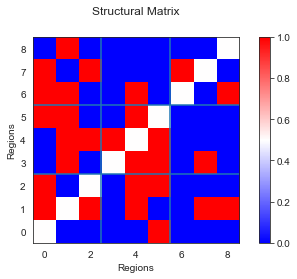

In [5]:
# Construct structural matrix
S = generateStructuralNetwork(args_dict = sim_args)

plt.hlines(y=2.5, xmin = -0.5, xmax = 8.5)
plt.hlines(y=5.5, xmin = -0.5, xmax = 8.5)
plt.vlines(x=2.5, ymin = -0.5, ymax = 8.5)
plt.vlines(x=5.5, ymin = -0.5, ymax = 8.5)

Note in this matrix:

`W[..., x]` : column x of matrix denotes all outgoing connection weights from node x  
`W[x, ...]` : row x of matrix denotes all incoming connection weights to node x

In [6]:
# Construct synaptic matrix
W = generateSynapticNetwork(S, showplot=False)

In [7]:
T = np.arange(0,sim_args['Tmax'],sim_args['dt'])

# Construct a community affiliation vector
Ci = np.repeat(np.arange(sim_args['ncommunities']),sim_args['nodespercommunity']) 
# Identify the regions associated with the hub network (hub network is by default the 0th network)
hub_ind = np.where(Ci==0)[0] 

stimsize = sim_args['nodespercommunity']

# This works because if there is a hub network the first nodes are the hub nodes
stim_nodes_td = np.arange(0, stimsize, dtype=int)
#stim_nodes_td

# Task structure

This network is stimulated topdown (i.e. only the hub nodes) with the following task:

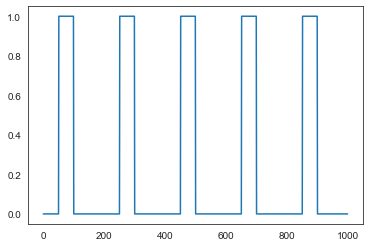

In [8]:
tasktiming, stimtimes = make_stimtimes(stim_nodes= stim_nodes_td, args_dict=sim_args)
plt.plot(tasktiming)

In [9]:
#stimtimes describes amount of stimulation (controlled by stim_mag) in each node for all time points
sim_args.update({'I':stimtimes})
taskdata, _ = networkModel(W, args_dict=sim_args)

# Network activity time course

Timeseries/activity for each node in each community.  

Since only the hub network is stimulated by the task the amount of activity will depend on number (/strength) of incoming connections from hub network nodes. If a node does not have any incoming connections from the hub network its activity will not change from 0.

Connections from the hub community to the other communities can be checked on the columns going out of the hub nodes (in this case the first three columns).

In [10]:
#Visualize what is going on on the network
#Three scatter plots with three curves for the timeseries/activity of each node in that community
taskdata_df = pd.DataFrame(taskdata)
taskdata_df['node_num'] = taskdata_df.index
taskdata_df['com_num'] = [0,0,0,1,1,1,2,2,2]
taskdata_df = taskdata_df.melt(id_vars = ['node_num', 'com_num'])
taskdata_df = taskdata_df.rename(columns={"variable": "time", "value": "activity"})

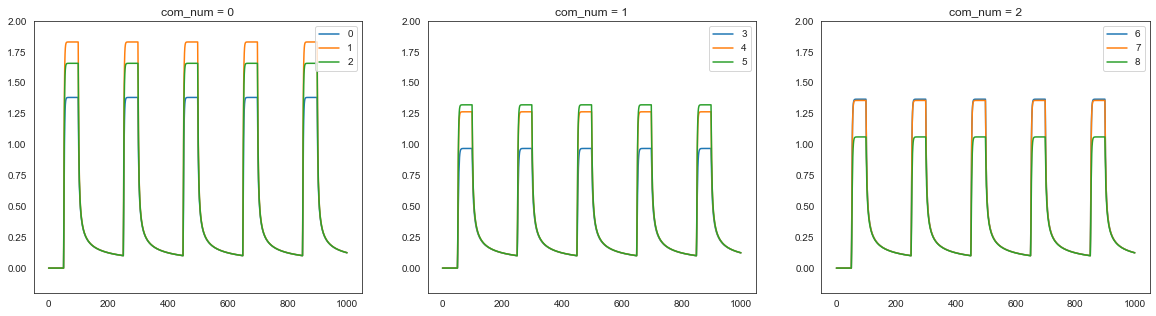

In [11]:
plt.rcParams["figure.figsize"][0] = 20
plt.rcParams["figure.figsize"][1] = 5
fig, a = plt.subplots(1, 3)

for cur_com in taskdata_df.com_num.unique():
    
    cur_vals = ["C"+str(x) for x in range(len(taskdata_df.query("com_num==@cur_com").node_num.unique()))]
    cur_col_lookup = dict(zip(taskdata_df.query("com_num==@cur_com").node_num.unique(), cur_vals))
    
    for cur_node in taskdata_df.query("com_num==@cur_com").node_num.unique():
        tmp = taskdata_df.query("com_num==@cur_com & node_num==@cur_node")
        a[cur_com].plot(tmp['time'], tmp['activity'], color = cur_col_lookup[cur_node], label = cur_node)
        a[cur_com].set_ylim([-0.2,2])
        a[cur_com].set_title("com_num = %s"%(str(cur_com)))
        a[cur_com].legend(loc="upper right")

Note that activity builds up and decreases in several time steps:

(-0.2, 2.0)

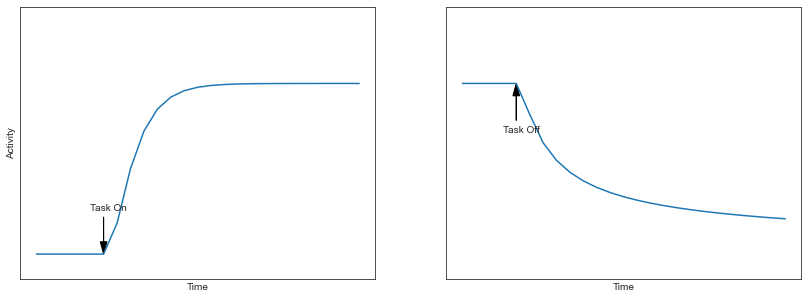

In [12]:
plt.rcParams["figure.figsize"][0] = 14
plt.rcParams["figure.figsize"][1] = 5
fig, a = plt.subplots(1, 2)

node = 0
task_on_t = np.where(np.diff(tasktiming) != 0)[0][0]
task_off_t = np.where(np.diff(tasktiming) != 0)[0][1]
range_start = 45
range_end = 70
plt_ranges = [range(range_start, range_end), range(range_start+50, range_end+50)]

a[0].plot(taskdata[node, plt_ranges[0]])
a[0].annotate("Task On", xy=(task_on_t - range_start-1, 0.35), xytext=(task_on_t - range_start-1, 0.35))
a[0].arrow(task_on_t - range_start, 0.3, 0, -0.2, head_width=0.5, head_length=0.1, fc='k', ec='k')
a[0].set_xticks([])
a[0].set_yticks([])
a[0].set_xlabel("Time")
a[0].set_ylabel("Activity")
a[0].set_ylim([-0.2,2])

a[1].plot(taskdata[node, plt_ranges[1]])
a[1].annotate("Task Off", xy=(task_off_t - (range_start+50)-1,  max(taskdata[node]) - .4), xytext=(task_off_t - (range_start+50)-1,  max(taskdata[node]) - .4))
a[1].arrow(task_off_t - (range_start+50), max(taskdata[node]) - .3, 0, 0.2, head_width=0.5, head_length=0.1, fc='k', ec='k')
a[1].set_xticks([])
a[1].set_yticks([])
a[1].set_xlabel("Time")
a[1].set_ylabel("")
a[1].set_ylim([-0.2,2])


# Comparison of design matrices

Back to the data generating process:

\begin{equation*}
\frac{dx_i}{dt}\tau_i = -x_i(t) + s\phi\big(x_i(t)\big) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(x_j(t)\big)\Bigg) + I_i(t)
\end{equation*}

\begin{equation*}
\tau_i\frac{dx_i}{dt}+ x_i(t) = s\phi\big(x_i(t)\big) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(x_j(t)\big)\Bigg) + I_i(t)
\end{equation*}

So the GLM to invert should be:


The extended GLM contains additional regressors to account for the node's own activity (recurrence) and the network activity (functional connectivity)

If we were to run an experiment we would not know $I_i(t)$, i.e. how the task affects each node. Instead we would only know the task structure that we impose and check for the relationship between this time course and the time course of activity in each node (operationally this means using `tasktiming` instead of `stimtimes` for the task regressor).

In [13]:
node = 0

#Drop the first time point
y = taskdata[node,1:]

#intercept
intcp = np.ones_like(y)

#Drop last time point
s_phi_x = sim_args['s']*phi(taskdata[node,:-1])

g_w_phi_x = np.delete(taskdata, node, axis=0)[:,:-1]
g_w_phi_x = np.apply_along_axis(phi, 0, g_w_phi_x)
cur_w = np.delete(W[node,:], node, axis=0)
cur_w = cur_w.reshape(-1,1)
g_w_phi_x = cur_w * g_w_phi_x
g_w_phi_x = np.sum(g_w_phi_x, axis=0)
g_w_phi_x = sim_args['g']*g_w_phi_x

# This is external; don't know how the task affects a node
# i_t = stimtimes[node,:-1]
i_t = tasktiming[:-1]

old_des_mat = np.column_stack((intcp, i_t))
new_des_mat = np.column_stack((intcp, s_phi_x, g_w_phi_x, i_t))

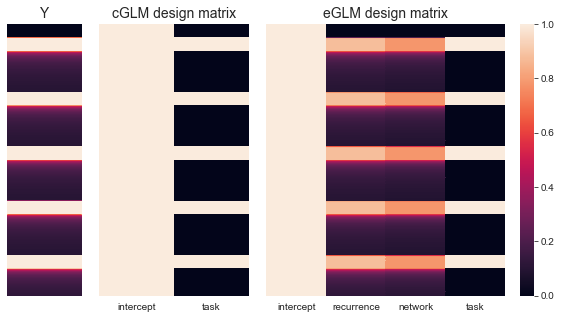

In [14]:
plt.rcParams["figure.figsize"][0] = 10
plt.rcParams["figure.figsize"][1] = 5
fig, a = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 2, 4]})

a[0].set_title("Y", fontdict = {'fontsize':14})
a[1].set_title("cGLM design matrix", fontdict = {'fontsize':14})
a[2].set_title("eGLM design matrix", fontdict = {'fontsize':14})

sns.heatmap(y.reshape(-1,1), xticklabels=False, yticklabels=False, cbar=False, ax = a[0], vmin = 0 , vmax = 1)
sns.heatmap(old_des_mat, xticklabels=['intercept', 'task'], yticklabels=False, cbar=False, ax = a[1], vmin = 0 , vmax = 1)
sns.heatmap(new_des_mat, xticklabels=['intercept', "recurrence", "network",'task'], yticklabels=False, cbar=True, ax = a[2], vmin = 0 , vmax = 1)

plt.subplots_adjust(wspace=0.1)

In [15]:
mod_df = pd.DataFrame(data = {"y": y, "s_phi_x":s_phi_x, "g_w_phi_x":g_w_phi_x, "i_t":i_t})
old_mod = smf.ols(formula = 'y ~ i_t', data = mod_df).fit()
mid_mod = smf.ols(formula = 'y ~ s_phi_x + g_w_phi_x', data = mod_df).fit()
new_mod = smf.ols(formula = 'y ~ s_phi_x + g_w_phi_x + i_t', data = mod_df).fit()

In [16]:
print("cGLM task parameter estimate: %s"%(str(round(old_mod.params['i_t'],3))))
print("eGLM task parameter estimate: %s"%(str(round(new_mod.params['i_t'],3))))

cGLM task parameter estimate: 1.168
eGLM task parameter estimate: 0.477


In [24]:
# y - (s_phi_x+g_w_phi_x+i_t)
#stimtimes[0]

Note: $s$ and $g$ are network properties that you wouldn't know about in emprical task data. But with empirical data it might possible to estimate these network properties from resting state data and then plug them in for task analyses.  

# Baseline calculation

To assess the "improvement" of the model we would like to compare the task involvement estimates to a "true" baseline since the data is synthetic. 

Standard model comparison of the reduction in sum of squared residuals as a function of the degrees of freedom isn't too informative in evaluating whether the addition of the two regressors improves our description of the relationship between the task regressor and network activity because a model with more parameters will always account for more of the variance in the data. We are interested in whether the variance is attributed to the correct regressors.  

Change in average activity when task is on compared to when task is off does not provide the "true" change in signal due to task becaus it is "contaminated" by network activity.  

Baseline should capture how much of the change in $y$ is due to $I(t)$ separate from the effect of recurrence and functional connectivity. In other words it is the regression weight of $I(t)$ in the extended model for **noiseless data.**  

This way, baseline does **NOT** depend on noise but it **DOES** depend on the node's connectivity (so it wouldn't be the same for all nodes, even all stimulated nodes).

## Stimulated node

The plot below shows the time course of one stimulated node's activity following a task on and task off period (dashed line). Additionally it also depicts the time course of each of the regressors and the predicted node activity time series from models with increasing complexity.

If we were to describe the effect of task on the node's time course using the raw time course of the task activity (blue line). This would overestimate the task involvement (the classic GLM case) as it must be multiplied with a large factor to approximate the dashed line. Furthermore as seen in the model predicted values (red line) there are systematic over and under estimations using just this regressor.

If we instead think of the data as a linear combination (brown line) of the task activity (blue), recurrent activity (yellow) and network activity (green) then we get a better approximation of the data. The task regressor coefficient in this case is our baseline.

Text(0.5, 0.98, 'Stimulated node')

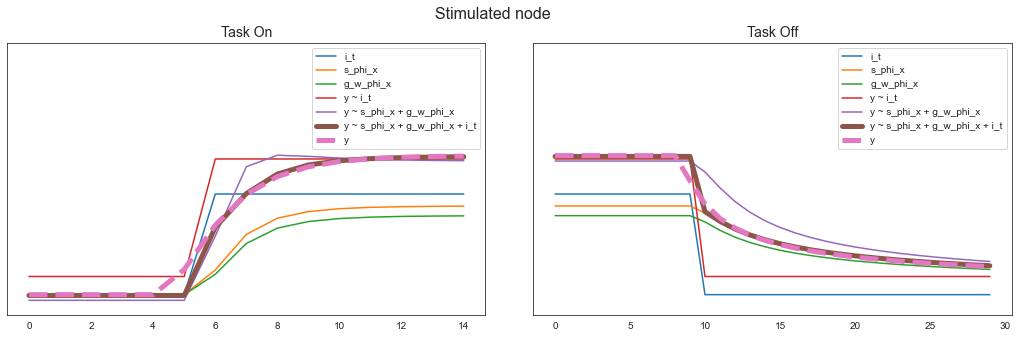

In [18]:
plt.rcParams["figure.figsize"][0] = 18
plt.rcParams["figure.figsize"][1] = 5
fig, a = plt.subplots(1, 2)

plt_ranges = [range(45,60), range(90,120)]
titles = ['Task On', "Task Off"]

for i, plt_range in enumerate(plt_ranges):
    a[i].plot(i_t[plt_range], label = "i_t")
    a[i].plot(s_phi_x[plt_range], label = "s_phi_x")
    a[i].plot(g_w_phi_x[plt_range], label = "g_w_phi_x")
    a[i].plot(old_mod.predict()[plt_range], label="y ~ i_t")
    a[i].plot(mid_mod.predict()[plt_range], label='y ~ s_phi_x + g_w_phi_x')
    a[i].plot(new_mod.predict()[plt_range], label='y ~ s_phi_x + g_w_phi_x + i_t', linewidth=5)
    a[i].plot(y[plt_range], label = "y", linewidth=5, linestyle='--')
    a[i].legend()
    a[i].set_title(titles[i], fontdict = {'fontsize':14})
#     a[i].set_xticks([])
    a[i].set_yticks([])
    a[i].set_ylim([-.2,2.5])
    
plt.subplots_adjust(wspace=0.1)
plt.suptitle("Stimulated node", size=16)

## Non-stimulated node

**Why is the baseline not 0?**

cGLM task parameter estimate: 1.144
eGLM task parameter estimate: 0.456


Text(0.5, 0.98, 'Non-stimulated node')

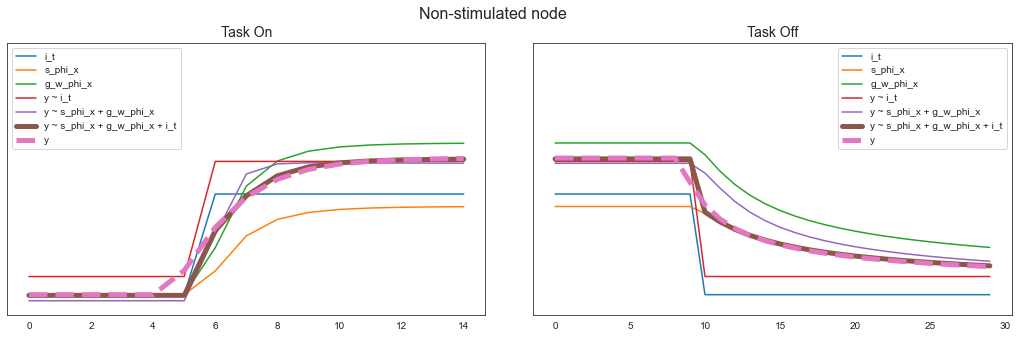

In [19]:
node = 7

#Drop the first time point
y = taskdata[node,1:]

#intercept
intcp = np.ones_like(y)

#Drop last time point
s_phi_x = sim_args['s']*phi(taskdata[node,:-1])

g_w_phi_x = np.delete(taskdata, node, axis=0)[:,:-1]
g_w_phi_x = np.apply_along_axis(phi, 0, g_w_phi_x)
cur_w = np.delete(W[node,:], node, axis=0)
cur_w = cur_w.reshape(-1,1)
g_w_phi_x = cur_w * g_w_phi_x
g_w_phi_x = np.sum(g_w_phi_x, axis=0)
g_w_phi_x = sim_args['g']*g_w_phi_x

# This is external; don't know how the task affects a node
# i_t = stimtimes[node,:-1]
i_t = tasktiming[:-1]

old_des_mat = np.column_stack((intcp, i_t))
new_des_mat = np.column_stack((intcp, s_phi_x, g_w_phi_x, i_t))

mod_df = pd.DataFrame(data = {"y": y, "s_phi_x":s_phi_x, "g_w_phi_x":g_w_phi_x, "i_t":i_t})
old_mod = smf.ols(formula = 'y ~ i_t', data = mod_df).fit()
mid_mod = smf.ols(formula = 'y ~ s_phi_x + g_w_phi_x', data = mod_df).fit()
new_mod = smf.ols(formula = 'y ~ s_phi_x + g_w_phi_x + i_t', data = mod_df).fit()

print("cGLM task parameter estimate: %s"%(str(round(old_mod.params['i_t'],3))))
print("eGLM task parameter estimate: %s"%(str(round(new_mod.params['i_t'],3))))

plt.rcParams["figure.figsize"][0] = 18
plt.rcParams["figure.figsize"][1] = 5
fig, a = plt.subplots(1, 2)

plt_ranges = [range(45,60), range(90,120)]
titles = ['Task On', "Task Off"]

for i, plt_range in enumerate(plt_ranges):
    a[i].plot(i_t[plt_range], label = "i_t")
    a[i].plot(s_phi_x[plt_range], label = "s_phi_x")
    a[i].plot(g_w_phi_x[plt_range], label = "g_w_phi_x")
    a[i].plot(old_mod.predict()[plt_range], label="y ~ i_t")
    a[i].plot(mid_mod.predict()[plt_range], label='y ~ s_phi_x + g_w_phi_x')
    a[i].plot(new_mod.predict()[plt_range], label='y ~ s_phi_x + g_w_phi_x + i_t', linewidth=5)
    a[i].plot(y[plt_range], label = "y", linewidth=5, linestyle='--')
    a[i].legend()
    a[i].set_title(titles[i], fontdict = {'fontsize':14})
#     a[i].set_xticks([])
    a[i].set_yticks([])
    a[i].set_ylim([-.2,2.5])
    
plt.subplots_adjust(wspace=0.1)
plt.suptitle("Non-stimulated node", size=16)

# Task parameter correction

In [20]:
sim_args.update({'W':W})
base_sim = sim_network_task_glm(args_dict=sim_args)

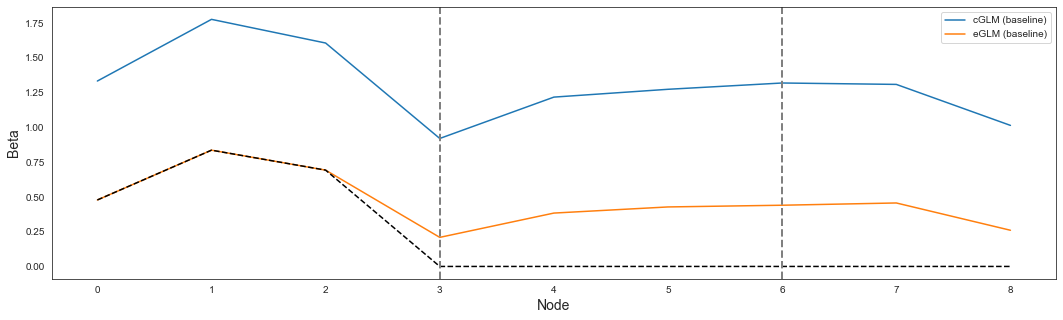

In [21]:
plot_sim_network_glm(base_sim, nnods = 3)